<img src="https://github.com/andremacias/att-rci-internal/blob/qa/RCI_DataAnalysis/eda/doc/att-logo.png" align="right" width=200 height=100>
<img src="https://github.com/andremacias/att-rci-internal/blob/qa/RCI_DataAnalysis/eda/doc/logo_axity.png" align="left" width=200 height=100>
<br>
<br>
<br>
<br>
<br>
<div style="float: right; width: 200%;">
<p style="margin: 0; padding-top: 20px; text-align:right;color:rgb(193, 38, 184)"><strong>Axity - AT&T.
    Ciclo de vida de elementos de inventario</strong></p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h1 align="center">Exploratory Data Analysis</h1>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>Descripción</h2>
    <p> Analizaremos los datos de las fuentes de inventarios de AT&T con un tratamiento estadístico descriptivo para hacer el tracking del ciclo de vida de los elementos de red.
        Este EDA contiene información general para la fuente de <b>Activo Fijo</b>. Los puntos a tratar son los siguientes:

<ol>
  <li>Recolección de datos.</li>
    <li>Descripción de la fuente.</li>
    <li>Exploración de los datos.</li>
    <li>Calidad de los datos.</li>
    <li>Preparación de los datos.</li>
    <li>Catálogos.</li>
    <li>KPI's</li>
</ol> 
    </p>

Primero cargamos las librerías necesarias.
</div>

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

import re
from pyspark.sql.functions import udf ,col
from pyspark.sql.types import IntegerType

In [2]:
conf = SparkConf().setAppName('EDA_Activo_Fijo_test')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import pandasql

from PIL import Image
from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.transform import cumsum
from bokeh.palettes import Category20_11, Category20c_20, PuRd3, viridis, Blues, plasma, Set1, Category20c
output_notebook()
%matplotlib inline

Loading BokehJS ...

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>1. Recolección de los datos</h2>
    <p> 
        Se toma una muestra representativa de la información que existe de Activo Fijo para comenzar con la recolección de los datos.
    </p>
</div>

In [4]:
#dfActivoFijo = spark.sql("SELECT activo, `location` as location_id , etiqueta, serie, descripcion, oc,vnl_asignado_mxn, vnl_del_activo_mxn, filedate, year, month, location_code, location_name,latitude, longitude FROM default.tx_fixed_asset a LEFT JOIN (SELECT a.location_code,a.location_name,a.latitude, a.longitude FROM (SELECT location_code,location_name, latitude, longitude, ROW_NUMBER() OVER (PARTITION BY location_code ORDER BY id_location DESC) ROW_NUM FROM inventario.raw_panda_location) a WHERE a.ROW_NUM = 1) b ON a.`location`= b.location_code WHERE a.year=2019 AND a.month = 10 AND a.day=1")

In [5]:
dfActivoFijo = spark.sql("SELECT activo, `location` as location_id , etiqueta, serie, descripcion, oc,vnl_asignado_mxn, vnl_del_activo_mxn, filedate, year, month, location_code, location_name,latitude, longitude FROM default.tx_fixed_asset a LEFT JOIN (SELECT a.location_code,a.location_name,a.latitude, a.longitude FROM (SELECT location_code,location_name, latitude, longitude, ROW_NUMBER() OVER (PARTITION BY location_code ORDER BY id_location DESC) ROW_NUM FROM inventario.raw_panda_location) a WHERE a.ROW_NUM = 1) b ON a.`location`= b.location_code WHERE a.year=2019 AND a.month = 10 AND a.day=1")

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Funcion que se encarga de manejar las reglas para la columna serie
    </p>
</div>

In [6]:
def validate_rule(string):
    
    search_list=[" ",'!','%','$',"<",">","^",'¡',"+","N/A",'¿','~','#','Ñ',"Ã","Åƒ","Ã‹","Ã³",'Ë','*','?',"ILEGIBLE", "VICIBLE","VISIBLE","INCOMPLETO"]
    test = u'%s' % (string)
    str_temp = string#test.decode('utf-8')
    if str_temp.upper() == "BORRADO":
      return 0
    elif len(str_temp) < 6:
      return 0
    elif any(ext.decode("utf-8") in str_temp.upper()for ext in search_list):
      return 0
    else:
      return 1

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se crea un udf en spark sobre la funcion ya creada 
    </p>
</div>

In [7]:
validate_rule_udf = udf(validate_rule, IntegerType())

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se le agrega una nueva columna al dataframe de spark; la nueva columna es la validacion de la columna serie con respecto al udf que creamos.
    </p>
</div>

In [8]:
df_serie = dfActivoFijo.withColumn("serie_cleaned",validate_rule_udf(col("serie")))

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se convierte el dataframe de spark a un dataframe de pandas 
    </p>
</div>

In [9]:
df = df_serie.toPandas()

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> Hemos recolectado los campos a analizar para Activo Fijo. A continuación se muestran las primeraras 10 filas.
    </p>
</div>

In [10]:
df.head(5)

activo location_id  etiqueta                 serie  \
0  1618240      0018CC  3G151466  215241253510C9000252   
1  2031140      1320MX  3G221298  215241307410E3000318   
2  1607932      0002FR  3G131098  215241253510C8000236   
3  2312892      M5729X  3G337164  2102310FVY10F7003283   
4  2664891      T1828X  00776636  2102311HXF10G5002735   

                      descripcion          oc vnl_asignado_mxn  \
0  RTN ODU 7GHZ O 15 GHZ O 23 GHZ                       352.37   
1  RTN ODU 7GHZ O 15 GHZ O 23 GHZ  1620140940          3241.15   
2  RTN ODU 7GHZ O 15 GHZ O 23 GHZ  1620120213          1163.58   
3     RRU AWS BAND 4T4R (RRU3841)  1620151202         29679.38   
4     RRU AWS BAND 4T4R (RRU3971)  1620160512         35741.25   

  vnl_del_activo_mxn  filedate  year  month location_code location_name  \
0             352.37  20191001  2019     10          None          None   
1            3241.15  20191001  2019     10          None          None   
2            1163.58  20191001  2019     10          None          None   
3           29679.38  20191001  2019     10          None          None   
4           35741.25  20191001  2019     10          None          None   

   latitude  longitude  serie_cleaned  
0       NaN        NaN              1  
1       NaN        NaN              1  
2       NaN        NaN              1  
3       NaN        NaN              1  
4       NaN        NaN              1

<div style="width: 100%; clear: both; font-family: Verdana;">
<h4>Diccionario de datos</h4>
    <p> 
    A continuación se enlistan los campos de la fuente con una breve descripción de negocio.
    <ul>
        <li><strong>activo</strong>: Número de activo.</li>
        <li><strong>units_assigned</strong>: Unidades asignadas al sitio.</li>
        <li><strong>location</strong>: Sitio al que fue asignado el activo.</li>
        <li><strong>etiqueta</strong>: Etiqueta del elemento.</li>
        <li><strong>serie</strong>: Número de serie del elemento.</li>
        <li><strong>descripcion</strong>: Descripción del elemento.</li>
        <li><strong>unidades</strong>: Número total de unidades.</li>
        <li><strong>retiro</strong>: Por definir.</li>
        <li><strong>oc</strong>: Número de orden de compra.</li>
        <li><strong>vnl_del_activo_mxn</strong>: Por definir.</li>
        <li><strong>vnl_asignado_mxn</strong>: Por definir.</li>
    </ul>
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>2. Descripción de las fuentes</h2>
    <p> En este apartado se hará una descripción a detalle de la fuente para una mejor comprensión de los datos. Se mostrarán las columas, los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h4>Columnas</h4>
</div>

In [11]:
df.head(10)

activo location_id  etiqueta                    serie  \
0  1618240      0018CC  3G151466     215241253510C9000252   
1  2031140      1320MX  3G221298     215241307410E3000318   
2  1607932      0002FR  3G131098     215241253510C8000236   
3  2312892      M5729X  3G337164     2102310FVY10F7003283   
4  2664891      T1828X  00776636     2102311HXF10G5002735   
5  2558677      00CY22  00843624     2102310SFMBTG3014152   
6  2023614      1110QR  3G216947     210231943310E2000440   
7   101353      ALM014     24521               CAE1AG0Z01   
8  2706354      00TX21            21340607132DN2764A97037   
9  2582662      00TN47    742690     2102310HBJBTFC006374   

                      descripcion          oc vnl_asignado_mxn  \
0  RTN ODU 7GHZ O 15 GHZ O 23 GHZ                       352.37   
1  RTN ODU 7GHZ O 15 GHZ O 23 GHZ  1620140940          3241.15   
2  RTN ODU 7GHZ O 15 GHZ O 23 GHZ  1620120213          1163.58   
3     RRU AWS BAND 4T4R (RRU3841)  1620151202         29679.38   
4     RRU AWS BAND 4T4R (RRU3971)  1620160512         35741.25   
5                           UPEUD  1620160502          1399.19   
6       RRU FOR WCDMA AWS (2*40W)  1620133449             0.00   
7                        Gabinete    20033779             0.00   
8   RRU OPTICAL TRANSCEIVER(9.8G)  1620160940           492.43   
9        RECTIFIER FOR APM30 V. D  1620160496          3445.16   

  vnl_del_activo_mxn  filedate  year  month location_code location_name  \
0             352.37  20191001  2019     10          None          None   
1            3241.15  20191001  2019     10          None          None   
2            1163.58  20191001  2019     10          None          None   
3           29679.38  20191001  2019     10          None          None   
4           35741.25  20191001  2019     10          None          None   
5            1399.19  20191001  2019     10          None          None   
6                0.0  20191001  2019     10          None          None   
7                0.0  20191001  2019     10          None          None   
8             492.43  20191001  2019     10          None          None   
9            3445.16  20191001  2019     10          None          None   

   latitude  longitude  serie_cleaned  
0       NaN        NaN              1  
1       NaN        NaN              1  
2       NaN        NaN              1  
3       NaN        NaN              1  
4       NaN        NaN              1  
5       NaN        NaN              1  
6       NaN        NaN              1  
7       NaN        NaN              1  
8       NaN        NaN              1  
9       NaN        NaN              1

In [12]:
df.columns.tolist()

['activo',
 'location_id',
 'etiqueta',
 'serie',
 'descripcion',
 'oc',
 'vnl_asignado_mxn',
 'vnl_del_activo_mxn',
 'filedate',
 'year',
 'month',
 'location_code',
 'location_name',
 'latitude',
 'longitude',
 'serie_cleaned']

<div style="width: 100%; clear: both; font-family: Verdana;">
<h4>Tipo de Datos</h4>
</div>

In [13]:
df.dtypes

activo                 object
location_id            object
etiqueta               object
serie                  object
descripcion            object
oc                     object
vnl_asignado_mxn       object
vnl_del_activo_mxn     object
filedate                int64
year                    int32
month                   int32
location_code          object
location_name          object
latitude              float64
longitude             float64
serie_cleaned           int32
dtype: object

<div style="width: 100%; clear: both; font-family: Verdana;">
<h4>Tamaño de la fuente</h4>
</div>

In [14]:
print('rows = ',df.shape[0],' columns = ',df.shape[1])

('rows = ', 1398204, ' columns = ', 16)


<div style="width: 100%; clear: both; font-family: Verdana;">
<h4>Estadísticas</h4>
</div>

In [15]:
df.describe(include='all')

activo location_id etiqueta    serie                    descripcion  \
count   1398204     1398204  1398204  1398204                        1398204   
unique  1118609       20873   835786   964761                          10246   
top     2905624      ALPMX1                    RRU OPTICAL TRANSCEIVER(9.8G)   
freq       7492       96333   562207   426607                         111668   
mean        NaN         NaN      NaN      NaN                            NaN   
std         NaN         NaN      NaN      NaN                            NaN   
min         NaN         NaN      NaN      NaN                            NaN   
25%         NaN         NaN      NaN      NaN                            NaN   
50%         NaN         NaN      NaN      NaN                            NaN   
75%         NaN         NaN      NaN      NaN                            NaN   
max         NaN         NaN      NaN      NaN                            NaN   

             oc vnl_asignado_mxn vnl_del_activo_mxn    filedate       year  \
count   1398204          1398204            1398204   1398204.0  1398204.0   
unique     6252           134514             118677         NaN        NaN   
top                         0.00                0.0         NaN        NaN   
freq      85114           272846             272846         NaN        NaN   
mean        NaN              NaN                NaN  20191001.0     2019.0   
std         NaN              NaN                NaN         0.0        0.0   
min         NaN              NaN                NaN  20191001.0     2019.0   
25%         NaN              NaN                NaN  20191001.0     2019.0   
50%         NaN              NaN                NaN  20191001.0     2019.0   
75%         NaN              NaN                NaN  20191001.0     2019.0   
max         NaN              NaN                NaN  20191001.0     2019.0   

            month location_code                               location_name  \
count   1398204.0        311165                                      311165   
unique        NaN          3009                                        2576   
top           NaN        ALPMX1  ALMACEN PROVISIONAL DHL MEXICO TEPOTZOTLAN   
freq          NaN         96333                                       96333   
mean         10.0           NaN                                         NaN   
std           0.0           NaN                                         NaN   
min          10.0           NaN                                         NaN   
25%          10.0           NaN                                         NaN   
50%          10.0           NaN                                         NaN   
75%          10.0           NaN                                         NaN   
max          10.0           NaN                                         NaN   

             latitude      longitude  serie_cleaned  
count   311165.000000  311165.000000   1.398204e+06  
unique            NaN            NaN            NaN  
top               NaN            NaN            NaN  
freq              NaN            NaN            NaN  
mean        20.599628     -99.907180   6.793279e-01  
std          2.881097       4.427476   4.667351e-01  
min          0.100000    -117.120608   0.000000e+00  
25%         19.551972     -99.207530   0.000000e+00  
50%         19.705082     -99.207530   1.000000e+00  
75%         19.705082     -99.181688   1.000000e+00  
max         32.670011      -0.100000   1.000000e+00

<div style="width: 100%; clear: both; font-family: Verdana;">
<p>
Se puede observar de la tabla que tenemos un total de <b>1,398,204</b> elementos totales.
    <ul>
        <li><strong>activos únicos</strong>: 1,398,204</li>
        <li><strong>activos duplicados</strong>: 279,595</li>
        <li><strong>números de serie únicos</strong>: 964,761</li>
        <li><strong>números de serie duplicados</strong>: 433,609</li>
    </ul>
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>3. Exploración de los datos</h2>
    <p> De acuerdo al análisis anterior, procedemos a hacer una exploración de los datos con gráficas.
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<p>
Se hace un proceso de normalización y visualización.
    Utilizaremos el campo de <b>location</b> para saber cual es sitio donde se asignan mas elementos. Revisamos los registros únicos en este campo para checar si necesitan limpieza:
    </p>
</div>

In [16]:
df.activo.replace('0',np.NaN,inplace=True)
df.location_id.replace('0',np.NaN,inplace=True)
df.etiqueta.replace('',np.NaN,inplace=True)
df.serie.replace('',np.NaN,inplace=True)
df.descripcion.replace('',np.NaN,inplace=True)
df.oc.replace('',np.NaN,inplace=True)
df.vnl_asignado_mxn.replace('',np.NaN,inplace=True)
df.vnl_del_activo_mxn.replace('',np.NaN,inplace=True)
df.location_code.replace('',np.NaN,inplace=True)
df.location_name.replace('',np.NaN,inplace=True)
df.latitude.replace('',np.NaN,inplace=True)
df.longitude.replace('',np.NaN,inplace=True)

In [17]:
df.location_name.unique().tolist()

[None,
 u'ALMACEN PROVISIONAL SANTA CECILIA',
 u'ALMACEN PROVISIONAL DHL MEXICO GLACO',
 u'RIO TUXPAN',
 u'ALMACEN PROVISIONAL DHL MEXICO TEPOTZOTLAN',
 u'PIE DE LA CUESTA',
 u'EL MAGUEY',
 u'SAMULA',
 u'ALIANZA',
 u'TIERRA COLORADA',
 u'SAN ANTONIO',
 u'PRADOS AGUA AZUL',
 u'FUERZA AEREA',
 u'PARQUE INDUSTRIAL ALLENDE',
 u'CARMONA',
 u'VILLA DORADA',
 u'COW COSS',
 u'BARRANCA',
 u'HOTELES',
 u'CARDIOLOGOS',
 u'LAZARO CARDENAS',
 u'LOMAS DEL NILO',
 u'EJERCITO MEXICANO',
 u'LOS OLIVOS',
 u'MIXCOAC',
 u'DEL VALLE',
 u'L9 ESTACION VELODROMO',
 u'SARABIA',
 u'JIMBA',
 u'SAN FELIPE',
 u'GALERIAS',
 u'LA PAZ',
 u'VIVEROS',
 u'TECNOLOGICO',
 u'L8 ESTACION BELLAS ARTES',
 u'HACIENDA LOS MORALES',
 u'CD BRISAS',
 u'MIGUEL ALEMAN',
 u'TANGAMANDAPIO',
 u'SAN ANGEL',
 u'TIRIPET\xcdO',
 u'SAN ANTONIO ABAD',
 u'BOMBAS',
 u'SAN JUAN DE ULUA',
 u'TANKAH',
 u'LOS HERRERA',
 u'EXCALE',
 u'TECOLUTLA',
 u'UNI XOCHICALCO',
 u'MEGA',
 u'L1 ESTACION ZARAGOZA',
 u'L7 ESTACION BARRANCA DEL MUERTO',
 u'L8 ESTA

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p>
        Ya que los sitios son demasiados, tomaremos los primeros 10 sitios que se repitan mas veces.
    </p>
</div>

In [19]:
mapa_locations=df.loc[:,['location_name','latitude','longitude']].dropna().drop_duplicates()
import folium
from folium import plugins

Latitud=21.607871
Longitud=-101.201933
mapa=folium.Map(location=[Latitud,Longitud],zoom_start=4.8)

places = folium.map.FeatureGroup()

for lat, lng, in zip(mapa_locations.latitude, mapa_locations.longitude):
    places.add_child(
        folium.features.Marker(
            [lat, lng]
        )
    )
    
latitudes = list(mapa_locations.latitude)
longitudes = list(mapa_locations.longitude)
labels = list(mapa_locations.location_name)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(places) 

mapa.add_child(places)

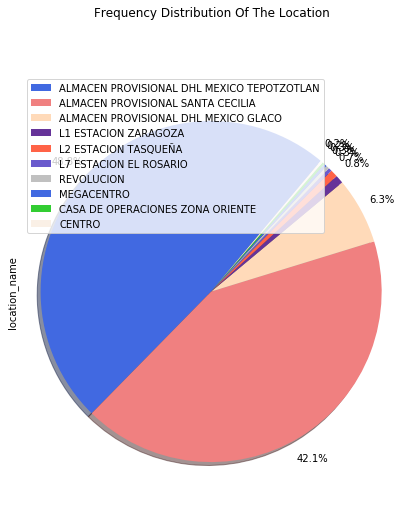

In [20]:
#Revisamos frecuencias:
locCont=pd.DataFrame(df.location_name.value_counts()[:10])

#Visualización:
fig=plt.figure()
ax1=fig.add_subplot(1,2,2)

#Subplot2: Bar chart
explode_list=[0,0,0,0,0,0,0,0,0,0]
color_list=['royalblue','lightcoral', 'peachpuff','rebeccapurple','tomato','slateblue','silver','royalblue','limegreen',
            'linen']
locCont['location_name'].plot(kind='pie',
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=50,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                    ax=ax1,
                    explode=explode_list)
ax1.set_title('Frequency Distribution Of The Location',y=1.12)
ax1.axis('equal')
ax1.legend(labels=locCont.index,loc='upper left')

plt.show()

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> Podemos realizar un histograma con estos mismos datos, primero debemos normalizar:
    </p>
</div>

In [21]:
ind=list(range(0,10))
principales=pd.DataFrame(df.location_id.value_counts()[:10])
location=principales.index
location=pd.DataFrame(location,index=ind)
location.columns=['Location_id']
principales.index=ind
principales.columns=['Frecuencias']

principales=pd.concat([location,principales],axis=1)

medios=df.location_id.value_counts()[10:70].sum()
Otros=df.location_id.value_counts()[70:].sum()

Medios=pd.DataFrame({'Location_id':'Medios','Frecuencias':medios},index=[0])
Otros=pd.DataFrame({'Location_id':'Otros','Frecuencias':Otros},index=[0])

Total=pd.concat([principales,Medios,Otros])
Total.reset_index(inplace=True,drop=True)
Total

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Frecuencias Location_id
0         96333      ALPMX1
1         83162      INFMEX
2         38884      ALM014
3         27335      MXOF06
4         14962      ALMDES
5         12448      ALPMX2
6          9742      013MSO
7          7722      MTRPRF
8          7286      INFGDL
9          5014      INFTIJ
10        55825      Medios
11      1039491       Otros

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> Después de hacer una normalización del catálogo ahora podemos hacer la visualización más adecuada como un histograma
        </p>
</div>

In [22]:
principales_aux=principales.set_index('Location_id')
principales_aux.plot(kind='bar',figsize=(10,6),rot=90,colormap='rainbow_r')
plt.xlabel('Location')
plt.ylabel('Frecuancia')
plt.title('Frecuencia de ubicaciones en Activo Fijo')

Text(0.5,1,'Frecuencia de ubicaciones en Activo Fijo')

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> Con las gráficas anteriores podemos apoyarnos para ver los datos de diferentes maneras.
        Estas gráficas nos muestran que con el location <b>ALPMX1</b> asignado al almacén de DHL Tepotzotlan es la ubicación donde se asignan mas activos con un 48.8%.
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>4. Calidad de los datos</h2>
    <p> Exploramos la calidad de los datos y analizaremos las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h4>Missings Values</h4>
    <p>Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí..
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Visualización de datos NOT NULL Activo Fijo </h4>
</div>

In [23]:
af_nas=df.isna().sum()
af_nas
porcentaje_af_nas=af_nas/df.isna().count()

columnas=list(porcentaje_af_nas.keys())
counts_nas=list(porcentaje_af_nas.values)
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1),
         title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.6, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
#pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='72b392dd-7e38-4c58-ae3e-f5455c39d3f9', ...)]


In [24]:
af_nas=df.isna().sum()
porcentaje_af_nas=af_nas/df.isna().count()

columnas=list(porcentaje_af_nas.keys())
counts_nas=list(porcentaje_af_nas.values)
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20_11))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_af_nas*100,columns=['Porcentaje'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 11), ('columnas', 16), ('counts_nas', 16)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


Porcentaje
activo                0.000000
location_id           0.000000
etiqueta             40.209226
serie                30.511070
descripcion           0.000000
oc                    6.087381
vnl_asignado_mxn      0.000644
vnl_del_activo_mxn    0.000572
filedate              0.000000
year                  0.000000
month                 0.000000
location_code        77.745379
location_name        77.745379
latitude             77.745379
longitude            77.745379
serie_cleaned         0.000000

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> Podemos notar que el porcentaje de valores nulos es mayor en los campos del catálogo con <b>77.7%</b>. Los campos de etiqueta y serie también cuenta con un porcentaje grande.
    </p>
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>5. Preparación de los datos</h2>
    <p> Para la preparación de los datos crearemos las reglas de calidad o estandares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos:
<ul>
    <li><strong>descripcion</strong>: eliminar acentos y pasar todo a mayúsculas.</li>
    <li>La unión de otras tablas con activo fijo se hará utilizando el número de serie y el activo.</li>
  </ul>
    </p>
      
</div>

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>6. Catálogos</h2>
    <p> Para Activo Fijo, se contempló el catálogo de raw_panda_location donde contiene información de los sitios. 
    </p>
</div>

In [25]:
cat_loc = spark.sql("SELECT * FROM inventario.raw_panda_location").toPandas()
cat_loc.head()

id_location  location_name                     street ext_number  \
0            0   NOT ASSIGNED                       None       None   
1            1  LA  TESTARUDA          Viaducto Diamante        S/N   
2            2     DEL TANQUE                 Del Tanque        S/N   
3            3     LOS AMATES    Carretera a Barra Vieja        S/N   
4            4       DIAMANTE  Boulevard de las Naciones       33-A   

  int_number                town postal_code cve_state   latitude  longitude  \
0       None                  NA        None      None   0.100000  -0.100000   
1        S/N     Ejido La Sabana        None       GRO  16.885025 -99.767142   
2       None            La Venta       39715       GRO  16.912520 -99.805420   
3       None  Plan de los Amates       39893       GRO  16.735277 -99.732300   
4       None    Olinalá Princess       39890       GRO  16.802707 -99.822429   

         ...         key_tx_type  key_renew_type  key_location_status  \
0        ...                None            None               LOCSRC   
1        ...               TXTMW            None               LOCTIP   
2        ...               TXTMW            None               LOCSIG   
3        ...               TXTMW            None               LOCSIG   
4        ...               TXTMW            None               LOCSIG   

  id_loc_rel key_energy_types temp_solution location_attid key_sec_lgt_tmp  \
0        NaN             None             0           None            None   
1        NaN             None             0           None            None   
2        NaN                              0     GROACA0042            None   
3        NaN                              0           None            None   
4        NaN                              0     GROACA0021            None   

  key_sec_lgt_loc_tmp key_agreement_type  
0                None               None  
1                None               None  
2                None               None  
3                None             AGRMTL  
4                None               None  

[5 rows x 52 columns]

<div style="width: 100%; clear: both; font-family: Verdana;">
<h2>7. KPI's</h2>
    <p> A continuación se presentan los cálculos y visualizaciones para los indicadores de Activo Fijo.</p>
</div>

In [26]:
df_af=df
df_af.replace(np.NaN,'vacio',inplace=True)

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo</h4>
</div>

In [27]:
Total_AF=pandasql.sqldf("SELECT COUNT(*) as Total_AF FROM df_af;", locals())
Total_AF

Total_AF
0   1398204

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo Trazables</h4>
</div>

In [28]:
Total_AF_Tr=pandasql.sqldf("SELECT COUNT(*) as Total_AF FROM (SELECT case when serie is null or length(serie) = 0 then 'vacio' else serie end serie, case when etiqueta is null or length(etiqueta) = 0 then 'vacio' else etiqueta end etiqueta FROM df_af)a WHERE serie <> 'vacio' or etiqueta <> 'vacio';", locals())                   
Total_AF_Tr

Total_AF
0   1078269

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo Trazables Únicos</h4>
</div>

In [29]:
Total_AF_Tr_Unic = pandasql.sqldf("SELECT COUNT(*) as Total_AF_Tr_Unic FROM (SELECT DISTINCT serie, etiqueta FROM df_af WHERE serie <> 'vacio' or etiqueta <> 'vacio')a;", locals())
Total_AF_Tr_Unic

Total_AF_Tr_Unic
0           1076746

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo Trazables Únicos con Número de Serie y Activo</h4>
</div>

In [30]:
df.columns

Index([u'activo', u'location_id', u'etiqueta', u'serie', u'descripcion', u'oc',
       u'vnl_asignado_mxn', u'vnl_del_activo_mxn', u'filedate', u'year',
       u'month', u'location_code', u'location_name', u'latitude', u'longitude',
       u'serie_cleaned'],
      dtype='object')

In [31]:
Total_AF_TrU_CS_CA = pandasql.sqldf("SELECT COUNT(*) as Total_AF_TrU_CS_CA FROM (SELECT DISTINCT serie,etiqueta  FROM (SELECT case when serie is null or length(serie) = 0 then 'vacio' else serie end serie, case when etiqueta is null or length(etiqueta) = 0 then 'vacio' else etiqueta end etiqueta FROM df_af)a WHERE serie <> 'vacio' and etiqueta <> 'vacio')b;", locals())           
Total_AF_TrU_CS_CA

Total_AF_TrU_CS_CA
0              729229

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo Trazables Únicos con Número de Serie sin Activo</h4>
</div>

In [32]:
Total_AF_TrU_CS_SA = pandasql.sqldf("SELECT COUNT(*) as Total_AF_TrU_CS_SA FROM (SELECT DISTINCT serie, etiqueta FROM (SELECT case when serie is null or length(serie) = 0 then 'vacio' else serie end serie, case when etiqueta is null or length(etiqueta) = 0 then 'vacio' else etiqueta end etiqueta FROM df_af)a WHERE serie <> 'vacio' AND etiqueta = 'vacio')b;", locals())
Total_AF_TrU_CS_SA

Total_AF_TrU_CS_SA
0              240953

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo Trazables Únicos sin Número de Serie con Activo</h4>
</div>

In [33]:
Total_AF_TrU_SS_CA = pandasql.sqldf("SELECT COUNT(*) AS Total_AF_TrU_SS_CA FROM (SELECT DISTINCT serie, etiqueta FROM (SELECT case when serie is null or length(serie) = 0 then 'vacio' else serie end serie, case when etiqueta is null or length(etiqueta) = 0 then 'vacio' else etiqueta end etiqueta FROM df_af)a WHERE serie = 'vacio' and etiqueta <> 'vacio')b;", locals())
Total_AF_TrU_SS_CA

Total_AF_TrU_SS_CA
0              106564

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo Duplicados</h4>
</div>

In [34]:
Total_AF_Tr_Dup = Total_AF_Tr - Total_AF_Tr_Unic.iloc[0,0]
Total_AF_Tr_Dup.columns=["Total_AF_Tr_Dup"]
Total_AF_Tr_Dup

Total_AF_Tr_Dup
0             1523

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Total Elementos en Activo Fijo No Trazables</h4>
</div>

In [35]:
Total_AF_NoTr = Total_AF - Total_AF_Tr.iloc[0,0]
Total_AF_NoTr.columns=["Total_AF_NoTr"]
Total_AF_NoTr

Total_AF_NoTr
0         319935

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p>Para las visualizaciones de los KPI, guardaremos las variables creadas para poder manipularlas mejor:</p>
</div>

In [36]:
Aux_Total_AF=Total_AF
Aux_Total_AF_Tr=Total_AF_Tr.iloc[0,0]
Aux_Total_AF_Tr_Unic=Total_AF_Tr_Unic.iloc[0,0]
Aux_Total_AF_TrU_CS_CA=Total_AF_TrU_CS_CA.iloc[0,0]
Aux_Total_AF_TrU_CS_SA=Total_AF_TrU_CS_SA.iloc[0,0]
Aux_Total_AF_TrU_SS_CA=Total_AF_TrU_SS_CA.iloc[0,0]
Aux_Total_AF_NoTr=Total_AF_NoTr.iloc[0,0]
Aux_Total_AF_Tr_Dup=Total_AF_Tr_Dup.iloc[0,0]


Cat3=['CS_CA','CS_SA','SS_CA']
colorlist=["#718dbf", "#e84d60"]
colorlistCat=["#c9d9d3", "#718dbf", "#e84d60"]
color_listxAlm=['royalblue','lightcoral','gold','mediumseagreen','#35B778']
CategoriaU=['Unicos','Duplicados']
CategoriaT=['Trazables','NoTrazables']

#Trazables vs No trazables
VATraza=[Aux_Total_AF_Tr,Aux_Total_AF_NoTr]
Trazabilidad=pd.DataFrame({'Trazabilidad':CategoriaT,
                          'TotalElementos':VATraza})
#Trazables en sus 3 categorías
TR3cat=[Aux_Total_AF_TrU_CS_CA,Aux_Total_AF_TrU_CS_SA,Aux_Total_AF_TrU_SS_CA]
Trazabilidad3Cat=pd.DataFrame({'Categorías_trazabilidad':Cat3,
                          'TotalElementos':TR3cat})

#Únicos vs duplicados
Uni_Dupli=[Aux_Total_AF_Tr_Unic,Aux_Total_AF_Tr_Dup]
TrazaUni_Dupli=pd.DataFrame({'Categoría_UvsD':CategoriaU,
                          'TotalElementos':Uni_Dupli})

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Trazables vs No Trazables</h4>
</div>

In [37]:
columnas=CategoriaT
Total=VATraza
source=ColumnDataSource(dict(columnas=columnas, 
                             Total=Total,
                             color=colorlist))

p=figure(x_range=columnas, 
         plot_height=300, 
         plot_width=850, 
         y_range=(0,2000000),         
         title='Elementos Trazables vs No trazables')
p.vbar(x='columnas',
       top='Total',
       width=.7, 
       color='color', 
       legend='columnas',
      source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
Trazabilidad

TotalElementos Trazabilidad
0         1078269    Trazables
1          319935  NoTrazables

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Trazables en sus 3 categorías</h4>
</div>

In [38]:
columnas=Trazabilidad3Cat['Categorías_trazabilidad']
Total=Trazabilidad3Cat['TotalElementos']
source=ColumnDataSource(dict(columnas=columnas, 
                             Total=Total,
                             color=colorlistCat))

p=figure(x_range=columnas, 
         plot_height=300, 
         plot_width=850, 
         y_range=(0,1000000),         
         title='Elementos Trazables vs No trazables')
p.vbar(x='columnas',
       top='Total',
       width=.4, 
       color='color', 
       legend='columnas',
      source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
Trazabilidad3Cat

Categorías_trazabilidad  TotalElementos
0                   CS_CA          729229
1                   CS_SA          240953
2                   SS_CA          106564

<div style="width: 100%; clear: both; font-family: Verdana;">
    <h4>Únicos vs Duplicados</h4>
</div>

In [39]:
columnas=TrazaUni_Dupli['Categoría_UvsD']
Total=TrazaUni_Dupli['TotalElementos']
source=ColumnDataSource(dict(columnas=columnas, 
                             Total=Total,
                             color=colorlist))

p=figure(x_range=columnas, 
         plot_height=300, 
         plot_width=850, 
         y_range=(0,1500000),         
         title='Elementos Únicos vs Duplicados')
p.vbar(x='columnas',
       top='Total',
       width=.7, 
       color='color', 
       legend='columnas',
      source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
TrazaUni_Dupli

Categoría_UvsD  TotalElementos
0         Unicos         1076746
1     Duplicados            1523

In [40]:
KPIs=pd.DataFrame({'KPI':['Total activos','Total activos trazables',
                         'Total activos trazables únicos','Total activos trazables únics con serie con activo',
                         'Total activos trazables únics con serie sin activo',
                         'Total activos trazables únics sin serie con activo',
                         'Total activos trazables únics duplicados','Total activos no trazables'],
                  'Resultado':[Total_AF,Total_AF_Tr,Total_AF_Tr_Unic,Total_AF_TrU_CS_CA,
                              Total_AF_TrU_CS_SA,Total_AF_TrU_SS_CA,Total_AF_Tr_Dup,Total_AF_NoTr]})

KPIs

KPI  \
0                                      Total activos   
1                            Total activos trazables   
2                     Total activos trazables únicos   
3  Total activos trazables únics con serie con ac...   
4  Total activos trazables únics con serie sin ac...   
5  Total activos trazables únics sin serie con ac...   
6           Total activos trazables únics duplicados   
7                         Total activos no trazables   

                                     Resultado  
0                         Total_AF
0   1398204  
1                         Total_AF
0   1078269  
2         Total_AF_Tr_Unic
0           1076746  
3     Total_AF_TrU_CS_CA
0              729229  
4     Total_AF_TrU_CS_SA
0              240953  
5     Total_AF_TrU_SS_CA
0              106564  
6           Total_AF_Tr_Dup
0             1523  
7               Total_AF_NoTr
0         319935

In [41]:
Total_AF_TrU_SS_CA

Total_AF_TrU_SS_CA
0              106564

In [42]:
sc.stop()